In [11]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt
import textwrap

from pprint import pprint
from fake_useragent import UserAgent
from sklearn.preprocessing import StandardScaler
from pyopt.client import PriceHistory
from scipy.optimize import minimize #import again

# Set some display options Pandas
pd.set_option("display.max_colwidth",None)
pd.set_option("expand_frame_repr",False)


In [12]:
# Define the symbols
symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "PEP", "NFLX", "ADBE",
    "AVGO", "CSCO", "TXN", "COST", "QCOM", "AMD", "INTC", "PYPL", "AMAT", "SBUX",
    # "HON", "BKNG", "TMUS", "ZM", "ISRG", "MRVL", "WMT", "LRCX", "MDLZ", "SNPS",
    # "GILD", "ILMN", "REGN", "KLAC", "CDNS", "CSX", "ADP", "XEL", "IDXX", "VRTX",
    # "MCHP", "ADI", "WDAY", "MNST", "MAR", "PANW", "ORLY", "ROST", "EXC", "WBA"
]


# Define risk free rate
rfr = 0.05

# Grab the number of Stocks in our Portfolio
number_of_symbols = len(symbols)

# Path to the CSV file
csv_file_path = r"C:\Users\pengx\Python\Portfolio Optimization\portfolio-optimization\data\stock_data.csv"

# If data from stock_data csv does not exist

# Generate a user agent
user_agent = UserAgent().chrome

# Define period as num_months
num_months = 120

# Initialize the PriceHistory Client and Define num_months of backtest data to draw from
price_history_client = PriceHistory(symbols=symbols, user_agent=user_agent, num_months=num_months)
user_agent=UserAgent().chrome

# Grab Data and Dump into a CSV File
price_history_client.price_data_frame.to_csv(csv_file_path, index=False)
# display(price_history_client.price_data_frame)

# Grab the data frame
price_data_frame: pd.DataFrame = price_history_client.price_data_frame

print(price_data_frame.head())


2014-08-22
2024-08-22
AAPL MSFT GOOGL AMZN TSLA NVDA META PEP NFLX ADBE AVGO CSCO TXN COST QCOM AMD INTC PYPL AMAT SBUX         date  close    volume    open     high    low symbol
0 2024-08-21  92.78   6769155  92.490  93.3800  92.22   SBUX
1 2024-08-20  93.01  11536230  92.290  93.8198  92.13   SBUX
2 2024-08-19  92.30  14479020  94.350  94.8900  92.13   SBUX
3 2024-08-16  94.81  16336330  93.355  95.6500  93.30   SBUX
4 2024-08-15  94.88  21109810  94.115  94.9600  92.98   SBUX


symbol         AAPL   ADBE    AMAT   AMD     AMZN    AVGO    COST   CSCO    GOOGL   INTC     META    MSFT     NFLX    NVDA    PEP  PYPL   QCOM    SBUX     TSLA    TXN
date                                                                                                                                                                  
2014-08-22  25.3300  72.04  22.170  4.25  16.5795  7.6210  121.29  24.65  29.6270  34.94  74.5700  45.150  68.4557  0.4770  91.60   NaN  76.82  38.640  17.1187  48.02
2014-08-25  25.3850  71.82  22.115  4.18  16.7010  7.5770  121.39  24.70  29.5285  34.81  75.0200  45.170  68.7043  0.4778  93.19   NaN  76.59  38.985  17.5033  47.37
2014-08-26  25.2222  71.53  22.230  4.19  17.0915  7.5955  121.09  24.81  29.4060  34.80  75.9601  45.005  68.4800  0.4864  92.60   NaN  77.01  38.895  17.4493  47.49
2014-08-27  25.5325  71.55  22.630  4.16  17.1590  7.6160  121.24  24.80  29.1500  34.79  74.6300  44.870  67.8143  0.4808  92.23   NaN  76.97  38.960  17.5500  47.7

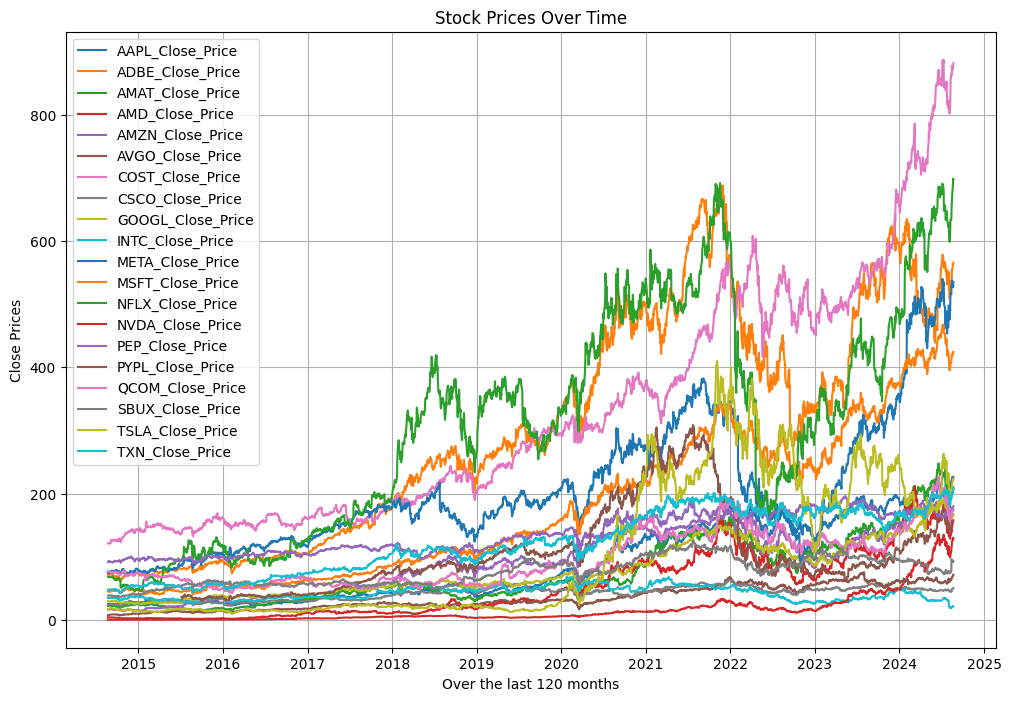

In [13]:
# Selecting date, symbol, close
price_data_frame = price_data_frame[["date", "symbol", "close"]]

# Pivot to have date as index and symbols as columns, and close price as values
price_data_frame = price_data_frame.pivot(
    index="date",
    columns="symbol",
    values="close"
)
print(price_data_frame.head())

# Plotting
plt.figure(figsize=(12, 8))
for symbol in price_data_frame.columns:
    plt.plot(price_data_frame.index, price_data_frame[symbol], label=f'{symbol}_Close_Price')

# Adding labels and title
plt.xlabel(f"Over the last {num_months} months")
plt.ylabel('Close Prices')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Sharpe Ratio:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio"s Excess Return} \\
\end{align}
$

Return of Portfolio:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

Standard Deviation of Portfolio"s Excess Return:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}
$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [14]:
# Calculate Log Returns
log_return = np.log(1 + price_data_frame.pct_change())

# Drop NaN values that might have appeared after calculating percentage changes
log_return = log_return.dropna()

# Generate Random Weights for the number of different stocks in our Portfolio
random_weights = np.array(np.random.random(number_of_symbols))

# Rebalanced sum of weights to 1
rebalanced_weights = random_weights / np.sum(random_weights)

print(rebalanced_weights)

# Calcualte the Expected Returns (annualized at 252 trading days)
exp_ret = np.sum((log_return.mean() * rebalanced_weights) * 252)

# Calculate Expected Volatility (annualized at 252 trading days)
exp_vol = np.sqrt(
    np.dot(
        rebalanced_weights.T,
        np.dot(
            log_return.cov() * 252,
            rebalanced_weights
        )
    )
)

# Calculate Sharpe Ratio with risk free rate
sharpe_ratio = (exp_ret - rfr) / exp_vol

[0.03954076 0.00426786 0.06544231 0.07846086 0.06098587 0.06082562
 0.06128923 0.02005579 0.03556189 0.06987642 0.04552498 0.06222488
 0.03095998 0.03027166 0.04191422 0.07560943 0.02931044 0.04229328
 0.06475291 0.08083162]


In [15]:
# Create data frame for weights
weights_df = pd.DataFrame(data={
    "random_weights": random_weights,
    "rebalanced_weights": rebalanced_weights,
})
print("")
print("="*80)
print("PORTFOLIO WEIGHTS")
print("-"*80)
print(weights_df)
print("-"*80)

# Create data frame for weights
metrics_df = pd.DataFrame(data={
    "Expected Portfolio Returns": exp_ret,
    "Expected Portfolio Volatiltiy": exp_vol,
    "Portfolio Sharpe Ratio": sharpe_ratio
}, index=[0])

print("")
print("="*80)
print("PORTFOLIO METRICS")
print("-"*80)
print(metrics_df)
print("-"*80)


PORTFOLIO WEIGHTS
--------------------------------------------------------------------------------
    random_weights  rebalanced_weights
0         0.441094            0.039541
1         0.047610            0.004268
2         0.730037            0.065442
3         0.875264            0.078461
4         0.680323            0.060986
5         0.678535            0.060826
6         0.683707            0.061289
7         0.223731            0.020056
8         0.396708            0.035562
9         0.779501            0.069876
10        0.507850            0.045525
11        0.694145            0.062225
12        0.345372            0.030960
13        0.337693            0.030272
14        0.467571            0.041914
15        0.843455            0.075609
16        0.326970            0.029310
17        0.471799            0.042293
18        0.722346            0.064753
19        0.901711            0.080832
--------------------------------------------------------------------------------


In [16]:
# Define quantity of simulations
num_of_portfolios = 10000

# Define risk free rate
rfr = 0.05

# Prep Weight Array of Numpy Zeros to store simulation results
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep Returns Array of Numpy Zeros to store simulation results
ret_arr = np.zeros((num_of_portfolios))

# Prep Volatility Array of Numpy Zeros to store simulation resultsps
vol_arr = np.zeros((num_of_portfolios))

# Prep Sharpe Ratio Array of Numpy Zeros to store simulation results
sharpe_arr = np.zeros((num_of_portfolios))

# Begin simulation
for ind in range(num_of_portfolios):

    # Generate random weights on each iteration; Sum of weights needs to be equal to 1
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights to the `weights_array`
    all_weights[ind, :] = weights

    # Calculate Expected Log Returns (annualized)
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate Volatility and add to `vol_arr`
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    ) 

    # Calculate Sharpe Ratio
    sharpe_arr[ind] = (ret_arr[ind] - rfr) / vol_arr[ind]

# Combine arrays
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a dataframe from the master array
simulations_df = pd.DataFrame(data=simulations_data).T

# Add column Names
simulations_df.columns = [
    "Returns",
    "Volatility",
    "Sharpe Ratio",
    "Portfolio Weights"
]

# Check data types of simulations_df
simulations_df = simulations_df

# Print out simulation dataframe
print("")
print("="*80)
print("Simulation Result")
print("-"*80)
print(simulations_df.head())
print("-"*80)



Simulation Result
--------------------------------------------------------------------------------
    Returns Volatility Sharpe Ratio                                                                                                                                                                                                                                                                                                                                                                                                                             Portfolio Weights
0  0.198886   0.250549     0.594241       [0.01007996746539118, 0.06918078050016606, 0.06629864487162763, 0.04388982492235588, 0.05591517014033691, 0.09501911380766294, 0.10399949873933519, 0.016321735361060862, 0.05692693876342239, 0.09752133151693587, 0.01361549850842462, 0.038262249209419015, 0.013910453396945941, 0.03917006494186909, 0.03313442261941417, 0.06900670571507654, 0.0016660567739719022, 0.059194828040989, 0.06266668

In [17]:
# Find Max Sharpe Ratio
max_sharpe_ratio = simulations_df.loc[simulations_df["Sharpe Ratio"].idxmax()]

# Find Min Volatility
min_volatility = simulations_df.loc[simulations_df["Volatility"].idxmin()]

print("")
print("="*80)
print("Max Sharpe Ratio")
print("-"*80)
print(max_sharpe_ratio)
print("-"*80)

print("")
print("="*80)
print("Min Volatility")
print("-"*80)
print(min_volatility)
print("-"*80)


Max Sharpe Ratio
--------------------------------------------------------------------------------
Returns                                                                                                                                                                                                                                                                                                                                                                                                                                               0.260826
Volatility                                                                                                                                                                                                                                                                                                                                                                                                                                            0.265216
Sharpe 

In [18]:
# %matplotlib inline

# # Plot data on Scatter Plot, Portfolio Returns vs Risk
# plt.scatter(
#     y=simulations_df["Returns"],
#     x=simulations_df["Volatility"],
#     c=simulations_df["Sharpe Ratio"],
#     cmap="YlGnBu"
# )

# # Add Title, Colorbar, x-axis, y-axis labels
# plt.title("Portfolio Returns v. Risk (Monte Carlo)")
# plt.colorbar(label="Sharpe Ratio")
# plt.xlabel("Standard Deviation / Risk")
# plt.ylabel("Returns")

# # Plot Max Sharpe Ratio using using a red star
# plt.scatter(
#     max_sharpe_ratio[1],
#     max_sharpe_ratio[0],
#     marker=(4,1,0),
#     color="r",
#     s=600
# )

# # Plot Min Volatility using using a blue star
# plt.scatter(
#     min_volatility[1],
#     min_volatility[0],
#     marker=(4,1,0),
#     color="b",
#     s=600
# )

# # Show Plot
# plt.show()

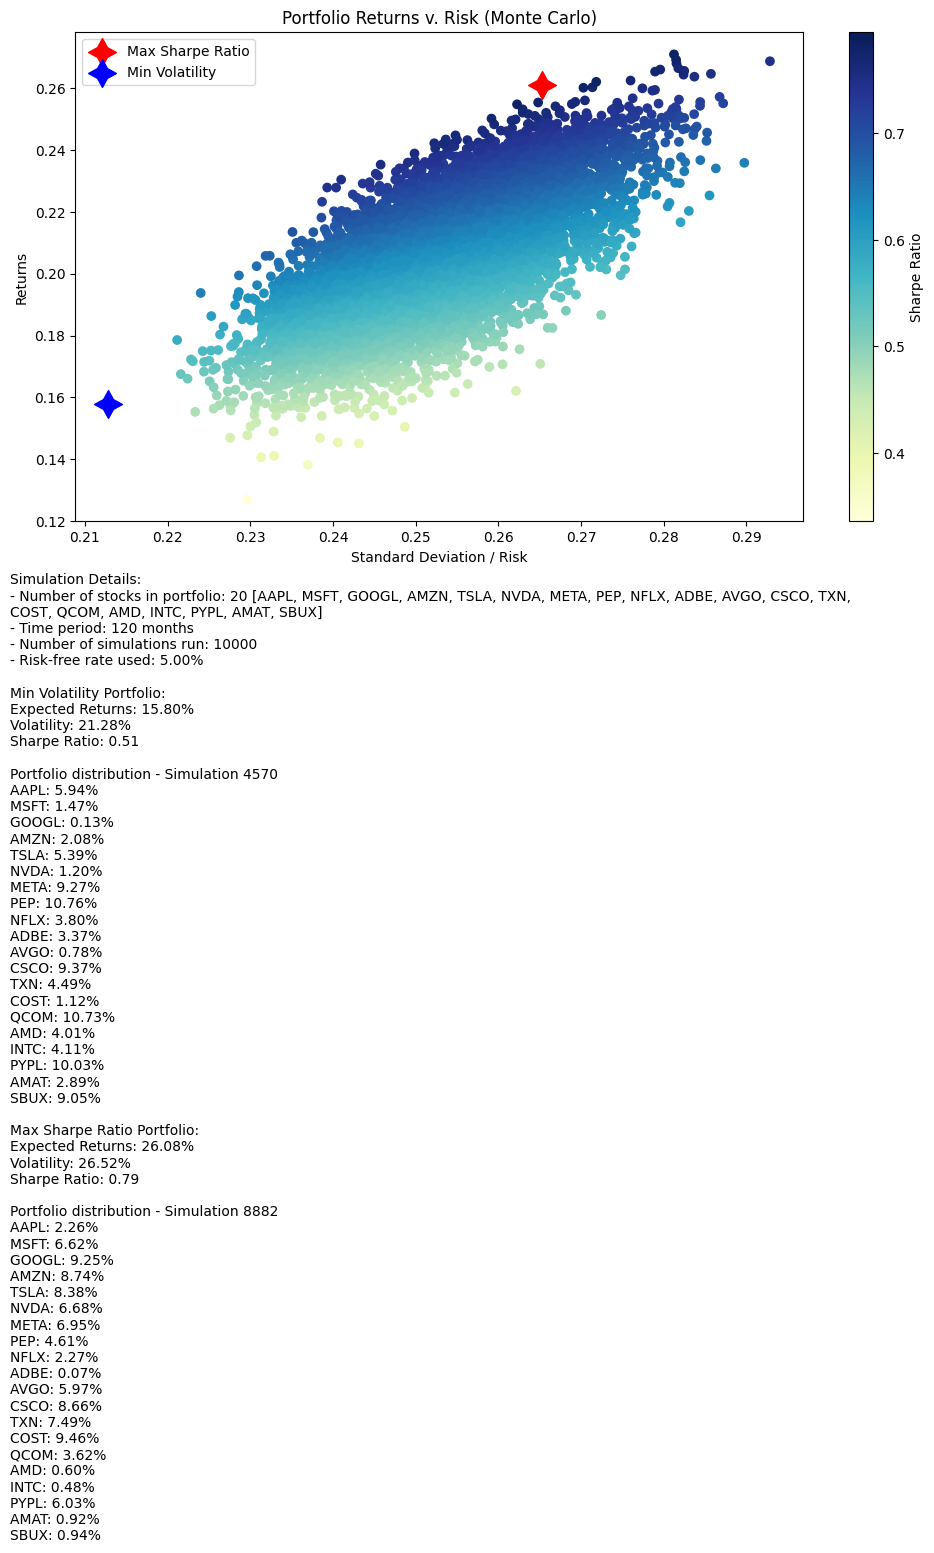

In [28]:
import matplotlib.pyplot as plt

# Calculate the number of lines of text based on your variables
num_lines_text = 6 + len(symbols) * 2  # Basic estimation

# Define a fixed gap between the plot and the text
fixed_gap = 0.5  # This is the vertical space between the plot and the details text

# Adjust the figure height accordingly (base height + additional height for text + gap)
fig_height = 6 + fixed_gap
plt.figure(figsize=(10, fig_height))

# Plot data on Scatter Plot, Portfolio Returns vs Risk
plt.scatter(
    y=simulations_df["Returns"],
    x=simulations_df["Volatility"],
    c=simulations_df["Sharpe Ratio"],
    cmap="YlGnBu"
)

# Add Title, Colorbar, x-axis, y-axis labels
plt.title("Portfolio Returns v. Risk (Monte Carlo)")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Standard Deviation / Risk")
plt.ylabel("Returns")

# Plot Max Sharpe Ratio using a red star
plt.scatter(
    max_sharpe_ratio["Volatility"],
    max_sharpe_ratio["Returns"],
    marker=(4, 1, 0),
    color="r",
    s=400,  # Size of the star marker
    label="Max Sharpe Ratio"
)

# Plot Min Volatility using a blue star
plt.scatter(
    min_volatility["Volatility"],
    min_volatility["Returns"],
    marker=(4, 1, 0),
    color="b",
    s=400,  # Size of the star marker
    label="Min Volatility"
)

# Restore the legend to its original position
plt.legend(loc='upper left')

# Convert the list of symbols into a comma-separated string
stock_list = ", ".join(symbols)

# Extract the index (simulation number) for min volatility and max Sharpe ratio portfolios
min_volatility_simulation_number = min_volatility.name
max_sharpe_simulation_number = max_sharpe_ratio.name

# Define metrics for Min Volatility and Max Sharpe Ratio portfolios
min_volatility_metrics = (
    f"Expected Returns: {min_volatility['Returns']:.2%}\n"
    f"Volatility: {min_volatility['Volatility']:.2%}\n"
    f"Sharpe Ratio: {min_volatility['Sharpe Ratio']:.2f}\n"
    f"\nPortfolio distribution - Simulation {min_volatility_simulation_number}\n"  # Add simulation number before listing the stock distribution
    + "\n".join([f"{symbol}: {weight:.2%}" for symbol, weight in zip(symbols, min_volatility['Portfolio Weights'])])
)

max_sharpe_metrics = (
    f"Expected Returns: {max_sharpe_ratio['Returns']:.2%}\n"
    f"Volatility: {max_sharpe_ratio['Volatility']:.2%}\n"
    f"Sharpe Ratio: {max_sharpe_ratio['Sharpe Ratio']:.2f}\n"
    f"\nPortfolio distribution - Simulation {max_sharpe_simulation_number}\n"  # Add simulation number before listing the stock distribution
    + "\n".join([f"{symbol}: {weight:.2%}" for symbol, weight in zip(symbols, max_sharpe_ratio['Portfolio Weights'])])
)

# Wrap the string about the number of stocks to fit the plot width
wrapped_stock_list = textwrap.fill(stock_list, width=80)

# Add simulation details text below the plot, aligned to the left
simulation_details = (
    "Simulation Details:\n"
    f"- Number of stocks in portfolio: {len(symbols)} [{wrapped_stock_list}]\n"
    f"- Time period: {num_months} months\n"
    f"- Number of simulations run: {num_of_portfolios}\n"
    f"- Risk-free rate used: {rfr:.2%}\n"
    "\nMin Volatility Portfolio:\n"
    f"{min_volatility_metrics}\n"
    "\nMax Sharpe Ratio Portfolio:\n"
    f"{max_sharpe_metrics}"
)

# Position the text below the plot
text_y_position = -fig_height/4.4
plt.gcf().text(0.01, text_y_position, simulation_details, fontsize=10, ha='left', color='black')

# Adjust the layout to ensure the text does not overlap with the plot
plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust the rect to leave space for the text

# Show Plot
plt.show()
